<a href="https://colab.research.google.com/github/dgsob/MT7051-VT25/blob/main/Group%20project/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

### MuJoCo engine set up

In [ ]:
# Install mujoco
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess

# Check if GPU is available
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config for Nvidia EGL driver
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was successful
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


### Imports

In [ ]:
# Gym
!pip install gymnasium
!pip install gymnasium-robotics
import gymnasium as gym
import gymnasium_robotics as robotics

# Rendering
!apt-get install -y xvfb
!pip install imageio ffmpeg pyvirtualdisplay
import imageio
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

# Training
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
from collections import namedtuple

# Saving the agent
import os
import pickle

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

### Define the environment

In [ ]:
# Initial plan: First tring in REACH, then check if the experience from it helps in solving PICK_AND_PLACE
REACH = "FetchReach-v3" # easiest one, arm reaches to a point
PICK_AND_PLACE = "FetchPickAndPlace-v3" # hardest one, arm reaches for the block, grabs it, reaches to a point

In [ ]:
def create_env(env_name="FetchReach-v3"):
    """Creates and returns a Gymnasium environment.

    Args:
        env_name (string, optional): The name of the environment to create.
            Defaults to: "FetchReach-v3"
            Valid options are:
                - "FetchReach-v3"
                - "FetchPickAndPlace-v3"

    Returns:
        gym.Env: The created Gymnasium environment.

    Prints:
        Observation space: The observation space of the environment.
        Action space: The action space of the environment.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    print("Observation space:", env.observation_space)
    print("Action space:", env.action_space)
    return env

### Run a random agent to test the env (commented out)

In [ ]:
# def run_random_actions(env, steps):
#     """Run a random agent in the environment for a given number of steps."""
#     frames = []
#     observation, info = env.reset()

#     for _ in range(steps):
#         action = env.action_space.sample()  # Sample a random action
#         obs, reward, terminated, truncated, info = env.step(action)

#         # Capture frame
#         frames.append(env.render())

#         # Stop if episode ends
#         if terminated or truncated:
#             break

#     env.close()
#     return frames

In [ ]:
# # Run everything
# env = create_env()
# frames = run_random_actions(env, steps=1000)
# imageio.mimsave("random_actions_fetch.gif", frames, fps=30)

# Training

### Device configuration (cuda)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Neural Networks

In [ ]:
# Define Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.max_action
        return x

# Define Critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Implementation: *HER*

In [ ]:
# Replay buffer with HER
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = []
        self.max_size = max_size
        self.ptr = 0

        # For storing entire episodes for HER
        self.episode_buffer = []

    def add(self, state, action, next_state, reward, done, goal):
        if len(self.buffer) < self.max_size:
            self.buffer.append(None)

        self.buffer[self.ptr] = (state, action, next_state, reward, done, goal)
        self.ptr = (self.ptr + 1) % self.max_size

    def add_episode_step(self, observation, action, next_observation, reward, done):
        """Store a step in the episode buffer with full observation dictionary"""
        self.episode_buffer.append((observation, action, next_observation, reward, done))

    def process_episode_with_her(self, env, k=4):
        """Process episode with HER, using the Gym-robotics style API"""
        episode_len = len(self.episode_buffer)

        # First, add the original experience to the replay buffer
        for i in range(episode_len):
            obs_dict, action, next_obs_dict, reward, done = self.episode_buffer[i]

            # Original experience with intended goal
            self.store_transition(obs_dict, action, next_obs_dict, reward, done)

            # HER: For k random future states (k=4 in our case)
            if k > 0:
                future_indices = np.random.randint(i, episode_len, size=min(k, episode_len-i))

                for future_idx in future_indices:
                    future_obs_dict = self.episode_buffer[future_idx][2]  # get the next observation at future step
                    achieved_goal = future_obs_dict["achieved_goal"]

                    # Use the future achieved goal as the desired goal
                    her_reward = env.unwrapped.compute_reward(
                        next_obs_dict["achieved_goal"],
                        achieved_goal,
                        info={}
                    )

                    # Store the transition with modified goal
                    self.store_transition(
                        obs_dict,
                        action,
                        next_obs_dict,
                        her_reward,
                        done,
                        new_goal=achieved_goal
                    )

        # Clear episode buffer for next episode
        self.episode_buffer = []

    def store_transition(self, obs_dict, action, next_obs_dict, reward, done, new_goal=None):
        """Store a processed transition in the replay buffer"""
        # If new_goal is provided, use it instead of the original desired_goal
        goal = new_goal if new_goal is not None else obs_dict["desired_goal"]

        # Create combined state vector
        state = np.concatenate([obs_dict["observation"], goal])
        next_state = np.concatenate([next_obs_dict["observation"], goal])

        # Add to buffer
        self.add(state, action, next_state, reward, done, goal)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.buffer), size=batch_size)

        states, actions, next_states, rewards, dones, goals = [], [], [], [], [], []

        for i in ind:
            s, a, s_, r, d, g = self.buffer[i]
            states.append(np.asarray(s))
            actions.append(np.asarray(a))
            next_states.append(np.asarray(s_))
            rewards.append(np.asarray(r))
            dones.append(np.asarray(d))
            goals.append(np.asarray(g))

        return (
            torch.FloatTensor(np.array(states)).to(device),
            torch.FloatTensor(np.array(actions)).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(np.array(rewards).reshape(-1, 1)).to(device),
            torch.FloatTensor(np.array(dones).reshape(-1, 1)).to(device),
            torch.FloatTensor(np.array(goals)).to(device)
        )

    def __len__(self):
        return len(self.buffer)

### Implementation: *DDPG*

In [ ]:
# DDPG with HER agent
class DDPG_HER:
    def __init__(self, state_dim, action_dim, goal_dim, max_action):
        # Our input to the actor and critic is state+goal, so we need to account for that in the dimensions
        input_dim = state_dim + goal_dim

        self.actor = Actor(input_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.001)

        self.critic = Critic(input_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.001)

        self.max_action = max_action # continuous action-values -> this is 1.0 for Fetch
        self.replay_buffer = ReplayBuffer()

        self.batch_size = 128 # 256 in literature
        self.gamma = 0.98 # arbitrary - not excplicitely stated in literature?
        self.tau = 0.05 # 0.95 in literature? sorprisingly high - did they just provide a complement?

    def select_action(self, observation, noise=0.1):
        """Select action based on observation dictionary"""
        # Create input by concatenating state and goal
        state = observation["observation"]
        goal = observation["desired_goal"]
        state_goal = np.concatenate([state, goal])
        state_goal = torch.FloatTensor(state_goal.reshape(1, -1)).to(device)

        with torch.no_grad():
            action = self.actor(state_goal).cpu().data.numpy().flatten()

        # Add noise for exploration
        if noise > 0:
            action = action + np.random.normal(0, noise, size=action.shape)

        return np.clip(action, -self.max_action, self.max_action)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample from replay buffer
        state, action, next_state, reward, done, goal = self.replay_buffer.sample(self.batch_size)

        # Compute target Q value
        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, next_action)
            target_Q = reward + (1 - done) * self.gamma * target_Q

        # Get current Q estimate
        current_Q = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

### Train Function

In [ ]:
def train_ddpg_with_her(env):
    # Set seeds
    seed = 0
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env_name = env.unwrapped.spec.id

    # Create agent
    obs_dict = env.reset()[0]
    state_dim = obs_dict["observation"].shape[0]  # 10
    action_dim = env.action_space.shape[0]  # 4
    goal_dim = obs_dict["desired_goal"].shape[0]  # 3
    max_action = float(env.action_space.high[0])  # 1.0

    agent = DDPG_HER(state_dim, action_dim, goal_dim, max_action)

    # Training parameters
    n_epochs = 50 # from literature
    n_cycles = 50 # from literature
    n_episodes = 16 # arbitrary
    n_timesteps = 50 # arbitrary

    # For evaluation (direct comparison with paper)
    success_history = []
    # and a typical learning curve (as usually used in the course)
    reward_history = []

    # Start training
    print("Starting training...")

    for epoch in range(n_epochs):
        successes = 0
        epoch_rewards = []  # track rewards for all episodes in this epoch

        for cycle in range(n_cycles):
            for episode in range(n_episodes):
                # Reset environment
                obs_dict, _ = env.reset()

                # Initialize tracking
                episode_success = False
                episode_reward = 0

                for t in range(n_timesteps):
                    # Select action with noise for exploration
                    action = agent.select_action(obs_dict, noise=0.2) # Gaussian with variance 0.2

                    # Execute action
                    next_obs_dict, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated

                    # Accumulate rewards
                    episode_reward += reward

                    # Store transition in episode buffer
                    agent.replay_buffer.add_episode_step(
                        obs_dict, action, next_obs_dict, reward, float(done)
                    )

                    # Update observations
                    obs_dict = next_obs_dict

                    # Track success
                    if info.get("is_success", 0) > 0:
                        episode_success = True

                    if done:
                        break

                # Process episode with HER
                agent.replay_buffer.process_episode_with_her(env, k=4)

                epoch_rewards.append(episode_reward)

                if episode_success:
                    successes += 1

            # Update policy after each cycle
            for _ in range(40):  # 40 batches per cycle - matches literature
                agent.train()

        # Calculate success rate and rewards for this epoch
        success_rate = successes / (n_cycles * n_episodes)
        success_history.append(success_rate)

        avg_reward = sum(epoch_rewards) / len(epoch_rewards)
        reward_history.append(avg_reward)

        print(f"Epoch {epoch+1}/{n_epochs}, Success Rate: {success_rate:.2f}, Reward: {avg_reward:.2f}")

    # Save trained model
    torch.save(agent.actor.state_dict(), f"{env_name}_actor.pth")

    return agent.actor, success_history, reward_history

### Run training with DDPG + HER

In [ ]:
env = create_env()
actor, success_history, reward_history = train_ddpg_with_her(env)

Observation space: Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (10,), float64))
Action space: Box(-1.0, 1.0, (4,), float32)
Starting training...
Epoch 1/50, Success Rate: 0.00, Reward: -50.00
Epoch 2/50, Success Rate: 0.01, Reward: -49.96
Epoch 3/50, Success Rate: 0.01, Reward: -49.96
Epoch 4/50, Success Rate: 0.02, Reward: -49.81
Epoch 5/50, Success Rate: 0.01, Reward: -49.87
Epoch 6/50, Success Rate: 0.07, Reward: -49.51
Epoch 7/50, Success Rate: 0.19, Reward: -47.97
Epoch 8/50, Success Rate: 0.27, Reward: -46.25
Epoch 9/50, Success Rate: 0.30, Reward: -44.62
Epoch 10/50, Success Rate: 0.33, Reward: -42.79
Epoch 11/50, Success Rate: 0.34, Reward: -41.98
Epoch 12/50, Success Rate: 0.36, Reward: -40.93
Epoch 13/50, Success Rate: 0.35, Reward: -40.64
Epoch 14/50, Success Rate: 0.35, Reward: -41.17
Epoch 15/50, Success Rate: 0.35, Reward: -42.08
Epoch 16/50, Success Rate: 0.37, Reward: -41.69
Epoch 17/5

# Load the actor from a file

In [ ]:
def load_agent(model_path, env):
    obs_dict = env.reset()[0]
    state_dim = obs_dict["observation"].shape[0]  # 10
    action_dim = env.action_space.shape[0]  # 4
    goal_dim = obs_dict["desired_goal"].shape[0]  # 3
    max_action = float(env.action_space.high[0])  # 1.0

    # Create agent with the same architecture
    input_dim = state_dim + goal_dim
    actor = Actor(input_dim, action_dim, max_action).to(device)

    # Load the saved weights
    actor.load_state_dict(torch.load(model_path))
    actor.eval()  # Set to evaluation mode

    return actor

# Evaluation

### Evaluate Function

In [ ]:
def evaluate(actor_model, env, n_episodes=10, max_steps=100):
    """
    Evaluates using just an actor model on multiple episodes and creates a single GIF
    with episodes playing one after another in sequence.

    Args:
        actor_model: The trained actor network
        env: The environment
        n_episodes: Number of episodes to run
        max_steps: Maximum steps per episode

    Returns:
        success_rate: Fraction of successful episodes
    """
    # Storage for sequential frames
    all_frames = []
    successes = 0
    env_name = env.unwrapped.spec.id
    device = next(actor_model.parameters()).device  # Get the device of the model

    # First get a sample frame to determine dimensions
    obs_dict, _ = env.reset()
    sample_frame = env.render()
    frame_height, frame_width = sample_frame.shape[0], sample_frame.shape[1]

    # Run all episodes sequentially
    for episode in range(n_episodes):
        obs_dict, _ = env.reset()
        episode_success = False

        # Episode title frame
        title_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
        pil_title = Image.fromarray(title_frame)
        draw = ImageDraw.Draw(pil_title)
        draw.text((frame_width//2 - 80, frame_height//2), f"Episode {episode+1}", fill=(255, 255, 255))
        all_frames.append(np.array(pil_title))

        # 5 blank frames as a pause between episodes
        for _ in range(5):
            all_frames.append(title_frame.copy())

        for t in range(max_steps):
            # Render the current state
            frame = env.render()

            # Add episode number as overlay
            pil_frame = Image.fromarray(frame)
            draw = ImageDraw.Draw(pil_frame)
            draw.text((10, 10), f"Episode {episode+1}", fill=(255, 255, 255))
            frame = np.array(pil_frame)

            # Add frame to full sequence
            all_frames.append(frame)

            # Select action using actor model directly
            state = obs_dict["observation"]
            goal = obs_dict["desired_goal"]
            state_goal = np.concatenate([state, goal])
            state_goal = torch.FloatTensor(state_goal.reshape(1, -1)).to(device)

            with torch.no_grad():
                action = actor_model(state_goal).cpu().data.numpy().flatten()

            # Step environment
            next_obs_dict, _, terminated, truncated, info = env.step(action)

            # Check success
            if info.get("is_success", 0) > 0:
                episode_success = True

            obs_dict = next_obs_dict

            if terminated or truncated:
                break

        # Make sure we have at least one frame from this episode
        if len(all_frames) == 0:
            all_frames.append(title_frame.copy())

        # Get the last frame for this episode
        last_frame = all_frames[-1].copy()

        # Mark episode result with a summary frame
        pil_result = Image.fromarray(last_frame)
        draw = ImageDraw.Draw(pil_result)
        status = "SUCCESS" if episode_success else "FAILURE"
        color = (0, 255, 0) if episode_success else (255, 0, 0)
        # Draw larger text for visibility
        draw.text((frame_width//2 - 80, frame_height//2),
                  status, fill=color)

        result_frame = np.array(pil_result)
        all_frames.append(result_frame)

        # Add a few still frames at the end of each episode to see the result
        for _ in range(15):  # Hold the result for 15 frames
            all_frames.append(result_frame.copy())

        # Track success
        if episode_success:
            successes += 1

    # Check if all frames have the same shape
    shapes = set(frame.shape for frame in all_frames)
    if len(shapes) > 1:
        print(f"Warning: Frames have different shapes: {shapes}")
        # Resize all frames to the dimensions of the first frame
        target_shape = all_frames[0].shape
        for i in range(len(all_frames)):
            if all_frames[i].shape != target_shape:
                pil_frame = Image.fromarray(all_frames[i])
                pil_frame = pil_frame.resize((target_shape[1], target_shape[0]), Image.LANCZOS)
                all_frames[i] = np.array(pil_frame)

    # Save as GIF
    imageio.mimsave(f"{env_name}_eval.gif", all_frames, fps=30, loop=0)
    print(f"Saved sequential animation to {env_name}_eval.gif")

    success_rate = successes / n_episodes
    print(f"Evaluation success rate: {success_rate:.2f}")

    return success_rate

### Run evaluation and save the gif

In [ ]:
env = create_env()
evaluate(actor, env, n_episodes=10)

Observation space: Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (10,), float64))
Action space: Box(-1.0, 1.0, (4,), float32)
Saved sequential animation to FetchReach-v3_eval.gif
Evaluation success rate: 0.60


0.6

# Plots from training

In [ ]:
import matplotlib.pyplot as plt

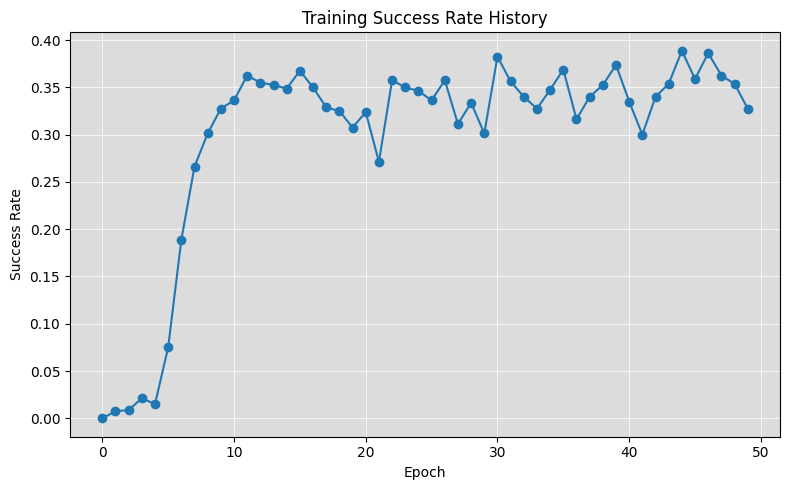

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.set_facecolor('gainsboro')
ax.plot(success_history, 'o-')
ax.grid(True, color='white', linestyle='-', linewidth=0.5)

plt.xlabel('Epoch')
plt.ylabel('Success Rate')
plt.title('Training Success Rate History')

plt.grid(True)
plt.tight_layout()
plt.savefig('learning_curve_success_rates.png', dpi=600)
plt.show()

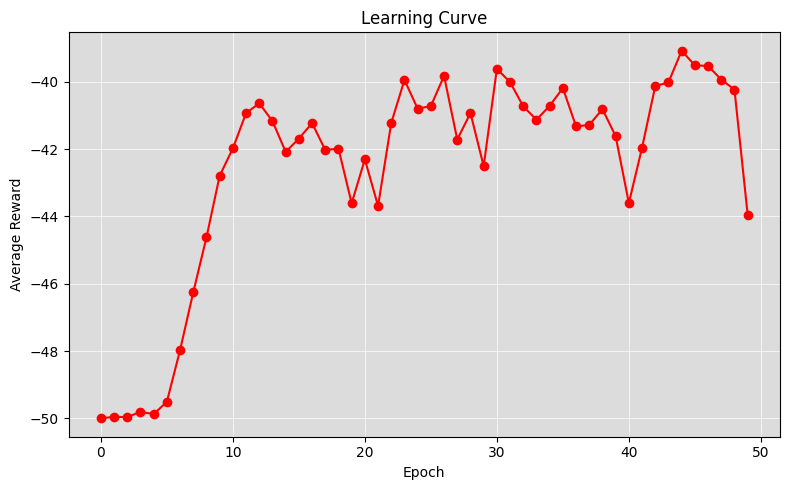

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.set_facecolor('gainsboro')
ax.plot(reward_history, 'o-r')
ax.grid(True, color='white', linestyle='-', linewidth=0.5)

plt.xlabel('Epoch')
plt.ylabel('Average Reward')
plt.title('Learning Curve')

plt.grid(True)
plt.tight_layout()
plt.savefig('learning_curve_rewards.png', dpi=600)
plt.show()